# Seismic inversion - Volve data

This notebook aims at presenting a simple example of colored seismic inversion.

We will use Volve data as input data to our inversion and we will leverage the open-source segyio and pylops libraries to accomplish our task as follows:

- Data is read from SEG-Y file using segyio (note that for the Volve data we will have to deal with irregular geometry)
- Colored inversion is applied by means of ``pylops.avo.poststack.PoststackInversion``
- Inverted data is saved back to SEG-Y file using segyio

We cannot provide the data given its size, but the Volve data is hosted on a Azure Blob storage so it is very easy to download it using the Azure CLI (https://github.com/Azure/azure-cli or ``pip install azure-cli`` would do).

First of all let's investigate what is present in the `Seismic` directory

In [1]:
#!az storage blob list --account-name dataplatformblvolve --container-name pub --prefix Seismic/ --sas-token "$YOURTOKEN" > ../data/seismicinversion/list_seismic.txt

In [2]:
!head -n 60 ../data/seismicinversion/list_seismic.txt

[
  {
    "content": null,
    "deleted": false,
    "metadata": null,
    "name": "Seismic/README.txt",
    "properties": {
      "appendBlobCommittedBlockCount": null,
      "blobTier": "Cool",
      "blobTierChangeTime": null,
      "blobTierInferred": true,
      "blobType": "BlockBlob",
      "contentLength": 1011,
      "contentRange": null,
      "contentSettings": {
        "cacheControl": null,
        "contentDisposition": null,
        "contentEncoding": null,
        "contentLanguage": null,
        "contentMd5": "VNB2po0tluppJS2dg4Y8WQ==",
        "contentType": "text/plain"
      },
      "copy": {
        "completionTime": null,
        "id": null,
        "progress": null,
        "source": null,
        "status": null,
        "statusDescription": null
      },
      "creationTime": "2018-05-14T09:37:35+00:00",
      "deletedTime": null,
      "etag": "0x8D5B97E533330A7",
      "lastModified": "2018-05-14T09:37:35+00:00",
      "lease": {
        "duration": null,
    

where you will need to substitute ``$YOURTOKEN`` with your personal token. To get a token, simply register at https://data.equinor.com/authenticate and find the token in the red text in the Usage section. Ensure to copy everything from `?sv=` to `=rl` in place of ``$YOURTOKEN``.

We can now download the file of interest

In [3]:
# TO BE RUN ONLY ONCE TO RETRIEVE THE DATA
#!az storage blob download --account-name dataplatformblvolve --container-name pub --name Seismic/ST10010/Stacks/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy --file ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy --sas-token "$YOURTOKEN"
#!mv ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy ../../data/pylops

Let's first import all the libraries we need

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import numpy as np
import segyio
import pylops
import matplotlib.pyplot as plt

And define some of the input parameters we will use later (refer to the following for a more detailed description of the types of inversion)

In [5]:
# Data
itmin = 600 # index of first time/depth sample in data used in colored inversion
itmax = 800 # number of samples of statistical wavelet

# Subsampling (can save file at the end only without subsampling)
jt = 1
jil = 1
jxl = 1

# Wavelet estimation
nt_wav = 21 # number of samples of statistical wavelet
nfft = 512 # number of samples of FFT

# Trace-by-Trace Inversion
epsI_tt = 1e-3 # damping

# Spatially simultaneous
niter_sr = 3 # number of iterations of lsqr
epsI_sr = 1e-4 # damping
epsR_sr = 1e2 # spatial regularization

# Blocky simultaneous
niter_out_b = 3 # number of outer loop iterations
niter_in_b = 1 # number of inner loop iterations
niter_b = 10 # number of iterations of lsqr
mu_b = 1e-1 # damping for data term
epsI_b = 1e-4 # damping
epsR_b = 0.1 # spatial regularization
epsRL1_b = 0.2 # blocky regularization

Let's now read the Volve data.

Note that we add the `ignore_geometry=True` parameter when we open the file. As we will see the geometry in this file is not regular, so we cannot rely on the inner working of segyio to get our data into a 3d numpy.

We thus need to read all ILs, XLs and traces and reorganize them ourselves into a regular grid. No worries, numpy will do most of the hard work.

(1961.0, 2680.0, 3200.0, 2404.0)

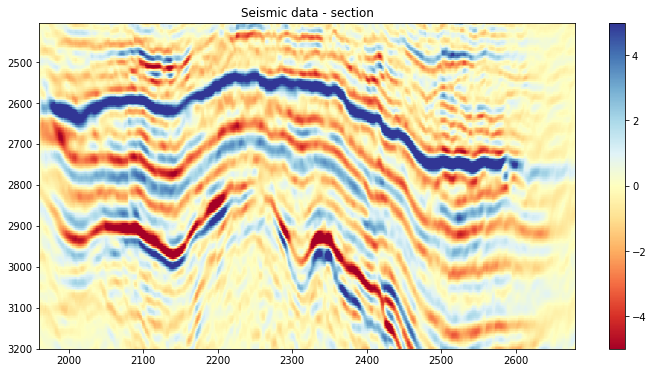

In [6]:
segyfile = '../data/seismicinversion/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy'
f = segyio.open(segyfile, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
traces = traces[:, itmin:itmax]
ntraces, nt = traces.shape

t = f.samples[itmin:itmax]
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

# Subsample
d = d[::jil, ::jxl, ::jt]
ilines = ilines[::jil]
xlines = xlines[::jxl]
t = t[::jt]
nil, nxl, nt = len(ilines), len(xlines), len(t)

# Display data
plt.figure(figsize=(12, 6))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Seismic data - section')
plt.colorbar()
plt.axis('tight')

Let's now try to get a quick estimate of the wavelet in our data using a simple statistical wavelet estimation in frequency domain.

Note that this notebook is not focused on the pre-processing but we will need access to this to apply a colored inversion.

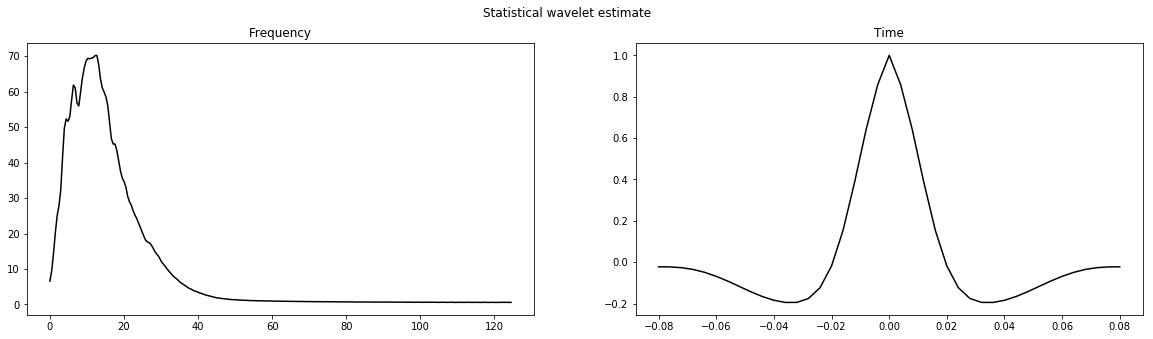

In [7]:
# Wavelet time axis
t_wav = np.arange(nt_wav) * (dt/1000)
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# Estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[::2, ::2], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# Create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

To the main part of our notebook, colored inversion. 

Let's quickly review the theory: we start from a seismic data and an estimated wavelet and we want to estimate a model of the acoustic impedance ($AI=v_p*\rho$). To achieve this we need to first look into the forward modelling problem (i.e., how I can model the seismic response from an AI profile and a wavelet):

$$d(t, \theta=0) = w(t) * \frac{dln(AI(t))}{dt}$$

where $AI(t)$ is the acoustic impedance profile and $w(t)$ is the time domain seismic wavelet. In compact form:

$$\mathbf{d}= \mathbf{W} \mathbf{D} \mathbf{ai}$$

where $\mathbf{W}$ is a wavelet convolution operator implemented via ``pylops.signalprocessing.Convolve1D`` and $\mathbf{D}$ is a derivative operator implemented via ``pylops.basicoperators.FirstDerivative``.


Post-stack (or colored) inversion is nothing more than the inverse process which aims at recovering the impedance profile from the band-limited seismic stack data.

For more details and examples: https://pylops.readthedocs.io/en/latest/tutorials/poststack.html#sphx-glr-tutorials-poststack-py

At this point we want to show how easy is to setup a new forward modelling in PyLops. After we will use a convenience function ``pylops.avo.poststack.PoststackInversion`` that will do the hard work for us

In [8]:
dims = (nt, nil, nxl)

# Create wavelet operator
Cop = pylops.signalprocessing.Convolve1D(np.prod(np.array(dims)), h=wav_est,
                                         offset=len(wav_est)//2, dir=0, dims=dims)

# Create derivative operator
Dop = pylops.basicoperators.FirstDerivative(np.prod(np.array(dims)), dims=dims,
                                            dir=0, sampling=1.)

Postop = Cop*Dop
print(Postop)

<57744000x57744000 _ProductLinearOperator with dtype=float64>


We can see how this operator works by simply applying its adjoint to the recorded data, and then again the forward to the adjoint model.

In [9]:
# Swap time axis back to first dimension
d = np.swapaxes(d, -1, 0) 

# Adjoint
m_adj = Postop.H * d.ravel()

# Forward
d_adj = Postop * m_adj

m_adj = m_adj.reshape(d.shape) 
d_adj = d_adj.reshape(d.shape) 

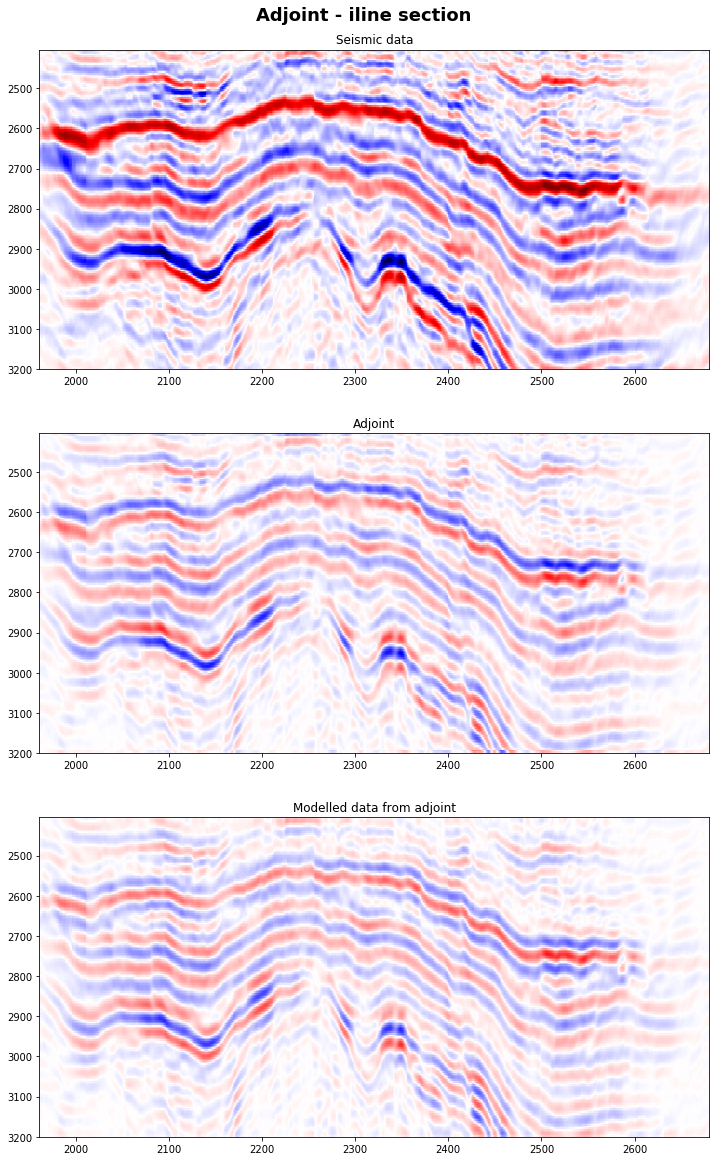

In [10]:
# Swap time axis back to last dimension
d = np.swapaxes(d, 0, -1)
d_adj = np.swapaxes(d_adj, 0, -1)
m_adj = np.swapaxes(m_adj, 0, -1)

# Visualize
fig, axs = plt.subplots(3, 1, figsize=(12, 20))
fig.suptitle('Adjoint - iline section',
             y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(m_adj[nil//2].T, cmap='seismic', vmin=-m_adj.max(), vmax=m_adj.max(),
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title('Adjoint');
axs[1].axis('tight')
axs[2].imshow(d_adj[nil//2].T, cmap='seismic', vmin=-d_adj.max(), vmax=d_adj.max(),
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title('Modelled data from adjoint')
axs[2].axis('tight');

In [11]:
%timeit -n 3 -r 2 Postop * m_adj.flatten()

1.78 s ± 5.43 ms per loop (mean ± std. dev. of 2 runs, 3 loops each)


And now we perform 3 different inversions:
    
- trace-by-trace
- simultaneous with smoothness constraints along spatial directions
- simultaneous with smoothness constraints along spatial directions and blockiness constrain along vertical direction


    

In [12]:
# Swap time axis back to first dimension
d = np.swapaxes(d, -1, 0)

# Inversion
m_colored, r_colored = \
    pylops.avo.poststack.PoststackInversion(d, wav_est, m0=np.zeros_like(d), explicit=True,
                                            epsI=epsI_tt, simultaneous=False)
m_colored_reg, r_colored_reg = \
    pylops.avo.poststack.PoststackInversion(d, wav_est, m0=m_colored, epsI=epsI_sr, epsR=epsR_sr,
                                            **dict(iter_lim=niter_sr, show=2))
m_blocky, r_blocky = \
    pylops.avo.poststack.PoststackInversion(d, wav_est, m0=np.zeros_like(d), explicit=False, 
                                            epsR=epsR_b, epsRL1=epsRL1_b,
                                            **dict(mu=mu_b, niter_outer=niter_out_b, 
                                                   niter_inner=niter_in_b, show=True,
                                                   iter_lim=niter_b, damp=epsI_b))

# Swap time axis back to last dimension
d = np.swapaxes(d, 0, -1)
m_colored = np.swapaxes(m_colored, 0, -1)
m_colored_reg = np.swapaxes(m_colored_reg, 0, -1)
m_blocky = np.swapaxes(m_blocky, 0, -1)

r_colored = np.swapaxes(r_colored, 0, -1)
r_colored_reg = np.swapaxes(r_colored_reg, 0, -1)
r_blocky = np.swapaxes(r_blocky, 0, -1)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 1.15488e+08 rows  and 5.7744e+07 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =        3
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.583e+05  3.583e+05    1.0e+00  1.1e-03
     1  2.66122e-05   2.288e+05  2.288e+05    6.4e-01  6.9e-01   4.9e+02  1.0e+00
     2  4.70190e-05   1.769e+05  1.769e+05    4.9e-01  3.3e-01   7.8e+02  2.3e+00
     3  6.09435e-05   1.508e+05  1.508e+05    4.2e-01  2.2e-01   9.7e+02  3.7e+00
 
LSQR finished
The iteration limit has been reached                      
 
istop =       7   r1norm = 1.5e+05   anorm = 9.7e+02   arnorm = 3.1e+07
itn   =       3   r2norm = 1.5e+05   acond = 3.7e+00   xnorm  = 8.9e+02
 
Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 57744000 rows and 57744

Let's finish with some visualization

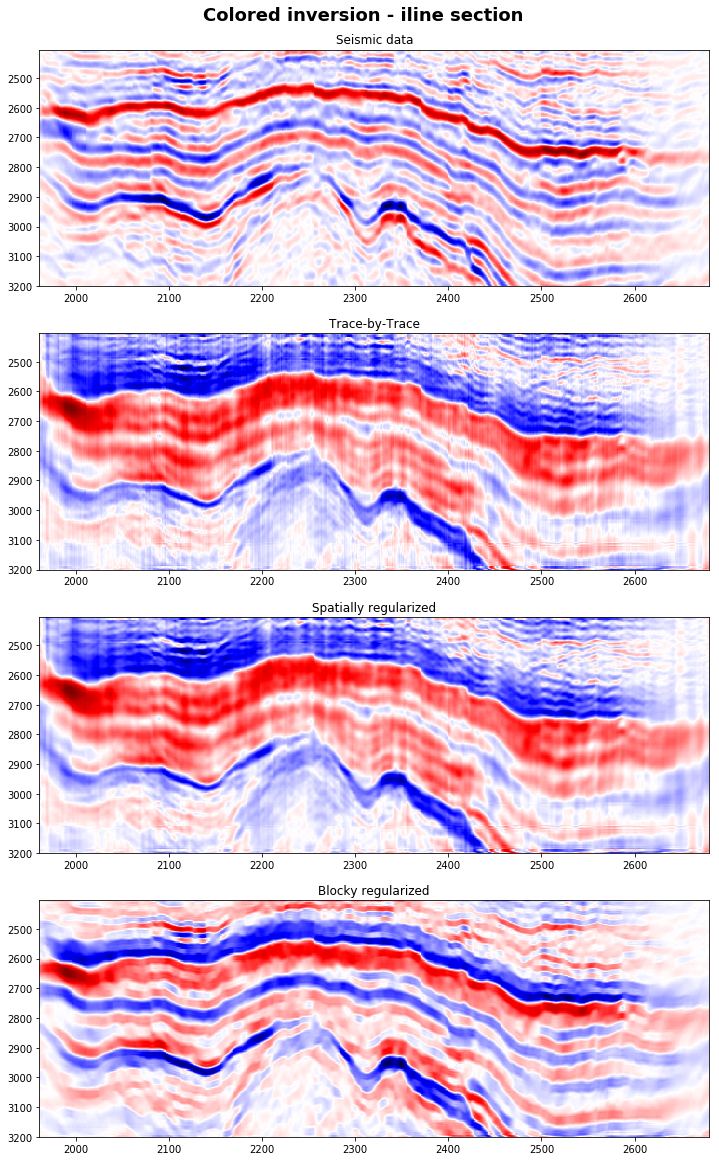

In [13]:
# Visualize
fig, axs = plt.subplots(4, 1, figsize=(12, 20))
fig.suptitle('Colored inversion - iline section',
             y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(m_colored[nil//2].T, cmap='seismic',
              vmin=-0.7*m_colored.max(), vmax=0.7*m_colored.max(),
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(m_colored_reg[nil//2].T, cmap='seismic',
              vmin=-0.7*m_colored.max(), vmax=0.7*m_colored.max(),
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight')
axs[3].imshow(m_blocky[nil//2].T, cmap='seismic',
              vmin=-0.4*m_colored.max(), vmax=0.4*m_colored.max(),
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title('Blocky regularized')
axs[3].axis('tight');

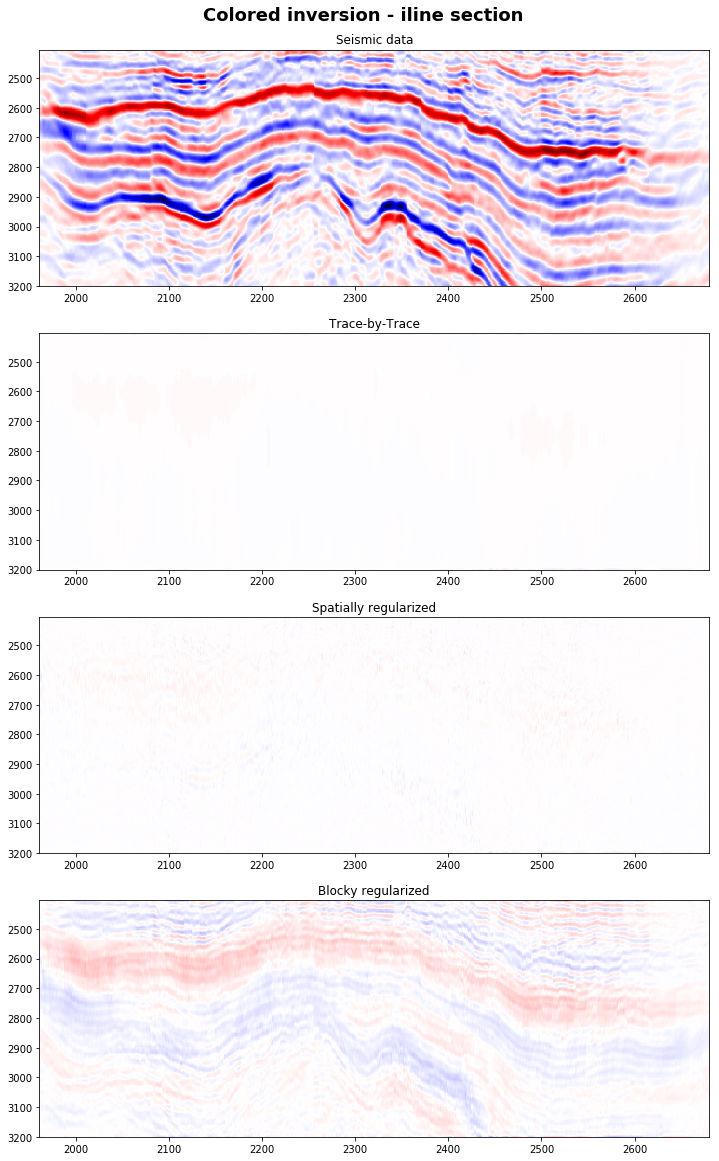

In [14]:
# Visualize
fig, axs = plt.subplots(4, 1, figsize=(12, 20))
fig.suptitle('Colored inversion - iline section',
             y=0.91, fontweight='bold', fontsize=18)
axs[0].imshow(d[nil//2].T, cmap='seismic', vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')
axs[1].imshow(r_colored[nil//2].T, cmap='seismic',
              vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')
axs[2].imshow(r_colored_reg[nil//2].T, cmap='seismic',
              vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight')
axs[3].imshow(r_blocky[nil//2].T, cmap='seismic',
              vmin=-10, vmax=10,
              extent=(xlines[0], xlines[-1], t[-1], t[0]))
axs[3].set_title('Blocky regularized')
axs[3].axis('tight');

Finally we write the cube back to a segy. As the geometry of the input data was irregular, we need to first bring the traces of the inverted cube back to their original order

In [15]:
traces_to_save =  m_colored_reg[ilgrid.ravel()[traces_available.ravel()],
                                xlgrid.ravel()[traces_available.ravel()]]

We can now use segyio once again to create a new SEG-Y with different time axis (or zoomed area) and populate it with both headers and data

In [16]:
segyfile = '../data/seismicinversion/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536.segy'
segyfile_inverted = '../data/seismicinversion/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536_inverted.segy'

with segyio.open(segyfile, ignore_geometry=True) as src:
        spec = segyio.spec()
        spec.format = int(src.format)
        spec.samples = t
        spec.tracecount = src.tracecount

        with segyio.create(segyfile_inverted, spec) as dst:
            # Copy all textual headers, including possible extended
            for i in range(src.ext_headers):
                dst.text[i] = src.text[i]

            # Copy the binary header, then insert the modifications needed for the new time axis
            dst.bin = src.bin
            dst.bin = {segyio.BinField.Samples: itmax-itmin}
            
            # Copy all trace headers to destination file
            dst.header = src.header 

            # Copy data and modify trace header
            for itrace in range(dst.tracecount):
                dst.header[itrace] = {segyio.TraceField.TRACE_SAMPLE_COUNT: itmax-itmin} 
                dst.trace[itrace] = traces_to_save[itrace].astype('float32')


Again, let's read the file back and check that what we saved is correct


In [17]:
f1 = segyio.open(segyfile_inverted, ignore_geometry=True)
traces1 = segyio.collect(f1.trace)[:]

In [18]:
np.allclose(traces1, traces_to_save)

True

In [19]:
!rm ../data/seismicinversion/ST10010ZC11_PZ_PSDM_KIRCH_FULL_D.MIG_FIN.POST_STACK.3D.JS-017536_inverted.segy